<a href="https://colab.research.google.com/github/Ugyenwangdi/Android_two_activities/blob/master/animegan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ugyenluci","key":"dd582b60413f39e06173999a62f20234"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [9]:

!kaggle datasets download splcher/animefacedataset


 97% 383M/395M [00:04<00:00, 119MB/s]
100% 395M/395M [00:04<00:00, 92.6MB/s]


In [10]:
!unzip -q -d dataset animefacedataset.zip

In [11]:
!pip install wandb
!wandb login

wandb: Currently logged in as: ugyen (use `wandb login --relogin` to force relogin)


Importing Required Libraries

In [13]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from torchsummary import summary
import wandb

import os, shutil
import imageio
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

print('Pytorch Version:', torch.__version__)
print('GPU Available:', torch.cuda.is_available())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Setting device to:', device)

ckpt_root = 'drive/MyDrive/Model-Checkpoints/Fake Anime - Pytorch'
if not os.path.isdir(ckpt_root):
    os.mkdir(ckpt_root)
    print('Making checkpoint dir for first time...')

progress_dir = os.path.join(ckpt_root, 'progress')
if not os.path.isdir(progress_dir):
    os.mkdir(progress_dir)
    print('Making progress dir for first time...')

Pytorch Version: 1.10.0+cu111
GPU Available: False
Setting device to: cpu


Creating data iterator

In [14]:
train_images = ImageFolder('dataset', transform = transforms.Compose([transforms.Resize(136),
                                                                     transforms.CenterCrop(128),
                                                                     transforms.RandomHorizontalFlip(),
                                                                     transforms.ToTensor(),
                                                                     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]))


Visualizing sample images from true data

In [15]:
def visualize_image(image):
    plt.figure(figsize = (5, 5))
    image = (image + 1) / 2

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
def visualize_batch(images_list, size = 14, shape = (6, 6), title = None, save = None, return_images = False):
    images_list = (images_list - images_list.min())/(images_list.max() - images_list.min())

    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.04)
    for ax, image in zip(grid, images_list):
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()
    
    if return_images:
        return images_list

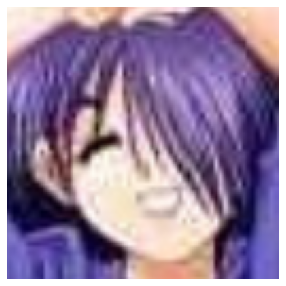

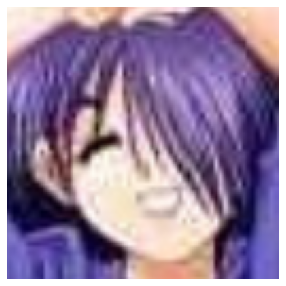

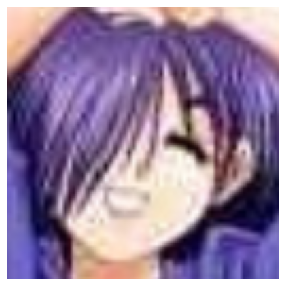

In [16]:
x, _ = train_images[0]
visualize_image(x)

x, _ = train_images[0]
visualize_image(x)

x, _ = train_images[0]
visualize_image(x)

Defining dataloader

In [17]:
batch_size = 128
train_data = DataLoader(train_images, batch_size = batch_size, shuffle = True, drop_last = True)

In [18]:
for x, _ in train_data:
    break

print(x.shape, x.min(), x.max())

torch.Size([128, 3, 128, 128]) tensor(-1.) tensor(1.)


Training Batch Samples


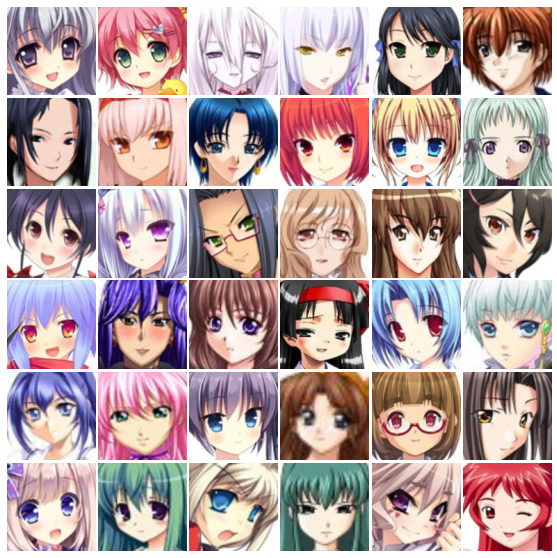

In [19]:


visualize_batch(x[:36], shape = (6, 6), size = 10, title = 'Training Batch Samples')




Creating the discriminator

In [20]:
class Discriminator(nn.Module):
    def __init__(self, maps = 64):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, maps, 4, 2, 1),
            nn.LeakyReLU(0.2), # shape -> maps, 64, 64
            
            nn.Conv2d(maps, 2 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(2 * maps),
            nn.LeakyReLU(0.2), # shape -> 2 * maps, 32, 32
            
            nn.Conv2d(2 * maps, 4 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(4 * maps),
            nn.LeakyReLU(0.2), # shape -> 4 * maps, 16, 16
            
            nn.Conv2d(4 * maps, 8 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(8 * maps),
            nn.LeakyReLU(0.2), # shape -> 8 * maps, 8, 8
            
            nn.Conv2d(8 * maps, 16 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(16 * maps),
            nn.LeakyReLU(0.2), # shape -> 16 * maps, 4, 4
        )

        self.outputs = nn.Sequential(
            nn.Conv2d(16 * maps, 1, 4, 1, 0),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.features(x)
        return self.outputs(x)


Summarizing the discriminator

In [21]:
discriminator = Discriminator(maps = 64).to(device)
summary(discriminator, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
        LeakyReLU-14           [-1, 102

Creating the generator

In [22]:
class Generator(nn.Module):
    def __init__(self, maps = 64, noise_size = 128):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(noise_size, 16 * maps, 4, 1, 0, bias = False),
            nn.BatchNorm2d(16 * maps),
            nn.ReLU(), # shape -> 16 * maps, 4, 4

            nn.ConvTranspose2d(16 * maps, 8 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(8 * maps),
            nn.ReLU(), # shape -> 8 * maps, 8, 8

            nn.ConvTranspose2d(8 * maps, 4 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(4 * maps),
            nn.ReLU(), # shape -> 4 * maps, 16, 16

            nn.ConvTranspose2d(4 * maps, 2 * maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(2 * maps),
            nn.ReLU(), # shape -> 2 * maps, 32, 32

            nn.ConvTranspose2d(2 * maps, maps, 4, 2, 1, bias = False),
            nn.BatchNorm2d(maps),
            nn.ReLU(), # shape -> maps, 64, 64

            nn.ConvTranspose2d(maps, 3, 4, 2, 1),
            nn.Tanh() # shape -> 3, 128, 128
        )

    def forward(self, z):
        z = z.view(-1, 128, 1, 1)
        return self.model(z)


Summarizing the generator

In [23]:
noise_size = 128
generator = Generator(maps = 64, noise_size = noise_size).to(device)
summary(generator, [[noise_size]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       2,097,152
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,


Initializing parameters

In [24]:


def initializer(module):
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
        nn.init.constant_(module.bias.data, 0.0)

discriminator.apply(initializer), generator.apply(initializer)

print('Initialization done...')



Initialization done...



Defining loss functions

In [25]:
ones = torch.ones(batch_size, 1).to(device)
zeros = torch.zeros(batch_size, 1).to(device)

def discrinimator_loss(true, false):
    return F.binary_cross_entropy_with_logits(true, ones) + F.binary_cross_entropy_with_logits(false, zeros)

def generator_loss(false):
    return F.binary_cross_entropy_with_logits(false, ones)


Defining optimizers

In [26]:
epochs = 50
lr = 0.0004

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))

Defining helper functions for saving and loading checkpoints

In [27]:
def save_checkpoint(epoch = 0, batch_index = 0):
    ckpt = {
        'fixed_z': fixed_z.cpu(),
        'generator': generator.state_dict(),
        'discriminator': discriminator.state_dict(),
        'generator_optimizer': generator_optimizer.state_dict(),
        'discriminator_optimizer': discriminator_optimizer.state_dict(),
        'epoch': epoch,
        'batch_index': batch_index
    }

    torch.save(ckpt, os.path.join(ckpt_root, 'ckpt.pth'))

def load_checkpoint():
    ckpt = torch.load(os.path.join(ckpt_root, 'ckpt.pth'))
    
    fixed_z = ckpt['fixed_z'].to(device)
    
    generator.load_state_dict(ckpt['generator'])
    discriminator.load_state_dict(ckpt['discriminator'])
    
    generator_optimizer.load_state_dict(ckpt['generator_optimizer'])
    discriminator_optimizer.load_state_dict(ckpt['discriminator_optimizer'])
    
    epoch = ckpt['epoch']
    batch_index = ckpt['batch_index']

    return fixed_z, epoch, batch_index

Defining noise generation functions

In [28]:
def random_noise(size):
    return torch.normal(0, 1, size, device = device)

Performing Initial load

In [ ]:
fixed_z = random_noise([36, noise_size])
save_checkpoint()


In [ ]:
fixed_z, start_epoch, start_batch_index = load_checkpoint()
print(f'Continuing from epoch {start_epoch} and batch index {start_batch_index}')

Setting up weights and biases for this run

In [32]:


# wandb_id = wandb.util.generate_id()
wandb_id = "2yp1ov6h"
print(wandb_id)
wandb.init(id = wandb_id, project = "Fake Anime - Pytorch", name = "Run 1")
wandb.config.update({
    'initial_lr': lr,
    'noise_size': noise_size,
    'initialization': 'Normal Distribution',
    'beta1': 0.5,
})



2yp1ov6h


wandb: Currently logged in as: ugyen (use `wandb login --relogin` to force relogin)


Training the model

In [ ]:
nan_break = False

discriminator.train()
generator.train()

for epoch in range(start_epoch, epochs):
    dcum_loss = 0.0
    gcum_loss = 0.0 
    
    dataloader = tqdm(train_data, desc = f'Epoch({epoch + 1}/{epochs})', ncols = '900')
    
    for batch_index, (true_images, _) in enumerate(dataloader, start_batch_index):
        batch_size = true_images.size(0)
        true_images = true_images.cuda()

        # [=========== Training Discriminator ===========]
        discriminator_optimizer.zero_grad()
        
        true = discriminator(true_images)
        
        false_images = generator(random_noise([batch_size, 128]))
        false = discriminator(false_images)

        d_loss = discrinimator_loss(true, false)
        d_loss.backward()
        discriminator_optimizer.step()
        
        # [============= Training Generator =============]
        generator_optimizer.zero_grad()
        
        false_images = generator(random_noise([batch_size, 128]))
        
        false = discriminator(false_images)
        g_loss = generator_loss(false)
        g_loss.backward()
        generator_optimizer.step()

        dataloader.set_postfix(d_loss = d_loss.item(), g_loss = g_loss.item())

        with torch.no_grad():
            dcum_loss += d_loss.item()
            gcum_loss += g_loss.item()

            wandb.log({'d_loss': d_loss.item(), 'g_loss': g_loss.item()})

            if (batch_index + 1) % (len(train_data) // 4) == 0 and batch_index != start_batch_index:
                generator.eval()
                false_images = generator(fixed_z).cpu()
                path_name = f"epoch({str(epoch + 1).zfill(len(str(epochs)))})-batch({str(batch_index + 1).zfill(len(str(len(train_data))))}).jpg"
                generator_images = visualize_batch(false_images,
                                                   shape = (6, 6),
                                                   size = 12,
                                                   save = os.path.join(progress_dir, path_name),
                                                   return_images = True,
                                                   title = "\nShowing Generated Samples\n")
                save_checkpoint

        if d_loss != d_loss or g_loss != g_loss:
            nan_break = True
            break
        
        if batch_index == len(train_data) - 1:
            break
        
    if nan_break:
        print(f'Nan loss occured at   : {epoch + 1}')
        print(f'Generator Loss        : {gcum_loss}')
        print(f'Discriminator Loss    : {dcum_loss}')
        break

    start_batch_index = 0

    print(f'\nEpoch: {epoch + 1}')
    print(f'Generator Loss        : {(gcum_loss/len(train_data)):.5f}')
    print(f'Discriminator Loss    : {(dcum_loss/len(train_data)):.5f}')

TypeError: ignored

TypeError: ignored

Generating progress gif

In [ ]:
images = []
sorted_image_names = sorted(os.listdir(progress_dir))
for file_name in sorted_image_names:
    file_path = os.path.join(progress_dir, file_name)
    if os.path.isfile(file_path):
        images.append(imageio.imread(file_path))
imageio.mimsave('anime-progress.gif', images, fps = 8)

Performing Image Interpolation

In [ ]:
def get_interpolations(noise1, noise2, num_interpolates):
    x = [((1.0 - (i/num_interpolates)) * noise1) + ((i/num_interpolates) * noise2) for i in range(num_interpolates + 1)]
    return torch.cat(x, dim = 0)

In [ ]:
with torch.no_grad():
    interpolations = []
    for _ in range(10):
        noise1 = random_noise([1, noise_size])
        noise2 = random_noise([1, noise_size])
        interpolations.append(get_interpolations(noise1, noise2, 9).to(device))
    
    interpolations = torch.cat(interpolations, dim = 0)
    false_images = generator(interpolations).cpu()
    print(f'\nShowing Generated Samples\n')
    visualize_batch(false_images, shape = (10, 10), size = 16, save = None)